In [1]:
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from load_data import load_data
from model import init_model

from rsl_depth_completion.conditional_diffusion.pipeline_utils import (
    get_ds_kwargs,
    setup_train_pipeline,
)

from rsl_depth_completion.conditional_diffusion.pipeline_utils import (
    create_tracking_exp,
)
from rsl_depth_completion.conditional_diffusion.img_utils import plot_sr_samples
from rsl_depth_completion.conditional_diffusion.img_utils import center_crop

torch.backends.cudnn.benchmark = True

In [10]:



logdir_name = "debug"

out_dir = f"/tmp/{logdir_name}" 
os.makedirs(out_dir, exist_ok=True)
# logdir_name = "standalone_trainer"
cfg, train_logdir = setup_train_pipeline(logdir_name, use_ssl=True)
cfg.disabled = True
cfg.input_res = 256
cfg.unets_output_res = [64,256]
cfg.only_super_res = True
cfg.use_triplet_loss=True
cfg.batch_size = 2

experiment = create_tracking_exp(cfg)

ds_kwargs = get_ds_kwargs(cfg)

ds, train_dataloader, val_dataloader = load_data(
    ds_name=cfg.ds_name, do_overfit=cfg.do_overfit, cfg=cfg, **ds_kwargs
)
x=ds[0]
overfit_batch = torch.utils.data.default_collate([x]*cfg.batch_size)
# eval_batch=overfit_batch

# tmp, as eval_batch is not loaded from dataset
eval_batch = ds.eval_batch
# eval_batch["rgb"] /= 255.0
# eval_batch["sdm"] *= ds.ds.max_depth
# eval_batch["gt"] = (center_crop(eval_batch["gt"], (256, 256), channels_last=False))

print(x['cond_img'].shape)
print(eval_batch['cond_img'].shape)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.


torch.Size([1, 256, 256])
torch.Size([2, 1, 256, 256])


In [11]:
from rsl_depth_completion.conditional_diffusion.custom_trainer_ssl import (
    ImagenTrainer as ImagenTrainerSSL,
)

cfg.use_super_res = True
unets, model = init_model(experiment, ds_kwargs, cfg, logdir_name)
trainer_kwargs = dict(
    imagen=model,
    use_lion=False,
    lr=5e-4,
    max_grad_norm=5e2,
    # fp16=cfg.fp16,
    fp16=False,
    use_ema=False,
    accelerate_log_with="comet_ml",
    accelerate_project_dir="logs",
)
trainer = ImagenTrainerSSL(**trainer_kwargs)
model_path = '/media/master/wext/msc_studies/second_semester/research_project/project/rsl_depth_completion/rsl_depth_completion/conditional_diffusion/models/plain_centerline_7375-unet-2-last.pt'
trainer.load(
    model_path,
    only_model=True,
)
# trainer.pose_model.eval()
print("loaded")

Using NullUnet as base unet
loading saved imagen at version 1.25.4, but current package version is 1.25.2
loaded


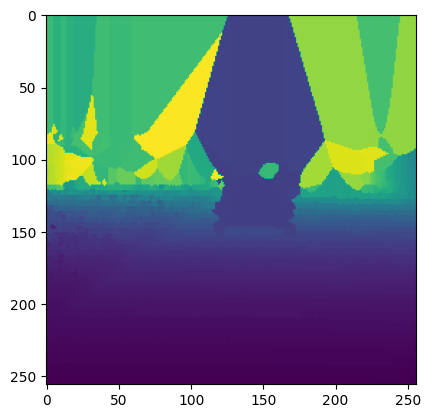

In [20]:
x=ds[2210]
overfit_batch = torch.utils.data.default_collate([x]*cfg.batch_size)
eval_batch=overfit_batch
# eval_batch=ds.eval_batch
plt.imshow(x['input_img'].cpu().numpy().transpose(1,2,0))

In [21]:
from rsl_depth_completion.conditional_diffusion.train_imagen_loop import sample
unet_idx=2
start_image_or_video = eval_batch['lowres_img']
output_depths = sample(
                        cfg,
                    trainer,
                    out_dir,
                    eval_batch,
                    1,
                    start_at_unet_number=unet_idx,
                    start_image_or_video=start_image_or_video,
                    stop_at_unet_number=unet_idx+1,
                    experiment=experiment,
)


unet 1 has not been trained
unet 2 has not been trained
when sampling, you can pass stop_at_unet_number to stop early in the cascade, so it does not try to generate with untrained unets


0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

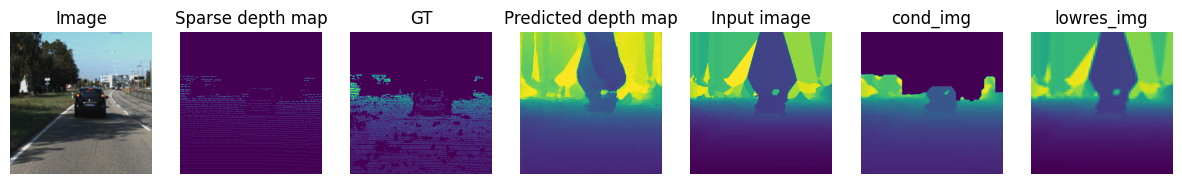

In [22]:
idx = -1
img, pred, sdm, gt, input_img, cond_img, lowres_img = (
    eval_batch["rgb"][idx],
    output_depths[idx][-1],
    eval_batch["sdm"][idx],
    eval_batch["gt"][idx],
    eval_batch["input_img"][idx],
    eval_batch["cond_img"][idx],
    eval_batch["lowres_img"][idx],
)
img = img.permute(1, 2, 0).cpu().numpy()
pred = pred.squeeze().cpu().detach().numpy()
sdm = sdm.squeeze().cpu().detach().numpy()
gt = gt.squeeze().cpu().detach().numpy()
input_img = input_img.permute(1, 2, 0).cpu().numpy()
cond_img = cond_img.permute(1, 2, 0).cpu().numpy()
lowres_img = lowres_img.permute(1, 2, 0).cpu().numpy()
fig, axs = plt.subplots(1, 7, figsize=(15, 5))
axs[0].imshow(img)
axs[1].imshow(sdm)
axs[2].imshow(gt.squeeze())
axs[3].imshow(pred)
axs[4].imshow(input_img)
axs[5].imshow(cond_img)
axs[6].imshow(lowres_img)
axs[0].set_title("Image")
axs[1].set_title("Sparse depth map")
axs[2].set_title("GT")
axs[3].set_title("Predicted depth map")
axs[4].set_title("Input image")
axs[5].set_title("cond_img")
axs[6].set_title("lowres_img")
for ax in axs:
    ax.axis("off")
plt.show()